<a href="https://colab.research.google.com/github/Inawa22/risk-analysis-ml-project/blob/main/Market_behaviour_Model_through_volatility_and_regime_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook: Market Regime and Risk Analysis
1. Introduction

Objective

Business motivation

Analytical questions

2. Data collection

Load equity/index data via yfinance

Load macro data via fredapi or CSV

Merge datasets by date

3. Data preparation

Handle missing values

Compute returns

Compute rolling features

Align macro data

4. Exploratory analysis

Plot price, returns, volatility

Plot macro trends

Correlation analysis

5. Regime detection
Cluster or HMM on volatility

Visualise regimes over time

6. Feature engineering

Lag features

Interaction terms (optional)

7. Model training

Train baseline model

Train ML model

Cross-validate

8. Evaluation

Forecast accuracy

Regime classification accuracy

Performance during crises
9. Interpretation

Feature importance

SHAP values

Macro influence

10. Business implications

Decision thresholds

Risk alerts

Use in practice

11. Limitations & risks

Concept drift

Data delays

Overfitting

Regulatory issues

12. Conclusion

Summary

Next steps

##Install dependencies

In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn fredapi


Our main objective here is to model and analyse volatility through regime changes


Analytical questions:
Primary question

Q1 — Can we detect and predict changes in market volatility regimes, and link them to macroeconomic conditions?

Secondary questions

Q2 — Which macro variables are most associated with transitions into high-volatility regimes?

Q3 — Can we anticipate high-risk periods 5–10 days in advance?

Q4 — How reliable is the model during economic shocks (e.g. crises)?

We start by loading market data (S&P 500, 2005–date)

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download S&P 500 data
sp500 = yf.download("^GSPC", start="2005-01-01")

# Columns are MultiIndex, so we pick the level that contains OHLCV field names
field_names = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}

lvl0 = set(map(str, sp500.columns.get_level_values(0)))
lvl1 = set(map(str, sp500.columns.get_level_values(1)))

# If level 0 looks like fields, keep level 0; else keep level 1
if len(field_names.intersection(lvl0)) >= 3:
    sp500.columns = sp500.columns.get_level_values(0)
elif len(field_names.intersection(lvl1)) >= 3:
    sp500.columns = sp500.columns.get_level_values(1)
else:
    # last resort: flatten by joining both levels
    sp500.columns = [f"{a}_{b}" for a, b in sp500.columns]

# Keep standard OHLCV
sp500 = sp500.loc[:, ["Open", "High", "Low", "Close", "Volume"]].copy()
sp500.dropna(inplace=True)

print("INDEX TYPE:", type(sp500.index))
print("COLUMNS TYPE:", type(sp500.columns))
print("COLUMNS:", sp500.columns.tolist()[:10])
sp500.tail()


/tmp/ipython-input-1425920489.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2005-01-01")
[*********************100%***********************]  1 of 1 completed

INDEX TYPE: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
COLUMNS TYPE: <class 'pandas.core.indexes.base.Index'>
COLUMNS: ['Open', 'High', 'Low', 'Close', 'Volume']


Price,Open,High,Low,Close,Volume
Date,,,,,
2026-01-12,6944.120117,6986.330078,6934.069824,6977.270020,5019040000
2026-01-13,6977.410156,6985.830078,6938.770020,6963.740234,5091730000
2026-01-14,6937.410156,6941.299805,6885.740234,6926.600098,5530830000
2026-01-15,6969.459961,6979.339844,6937.930176,6944.470215,5114050000
2026-01-16,6960.540039,6967.299805,6925.089844,6940.009766,5356550000


##Feature engineering —
To define the features, we separate market and macro features

The market features are computed below

In [3]:
# Daily returns
sp500['return'] = sp500['Close'].pct_change()

# Rolling volatility
for window in [5, 10, 20]:
    sp500[f'vol_{window}d'] = sp500['return'].rolling(window).std()

# Rolling volume
sp500['vol_volume_20d'] = sp500['Volume'].rolling(20).mean()

# High–low range
sp500['hl_range'] = (sp500['High'] - sp500['Low']) / sp500['Close']

# Momentum
sp500['momentum_5d'] = sp500['return'].rolling(5).sum()
sp500['momentum_10d'] = sp500['return'].rolling(10).sum()

sp500.dropna(inplace=True)

Define the target variable (risk regime)

In [4]:
# 20-day realised volatility
sp500['realised_vol_20d'] = sp500['return'].rolling(20).std()

# High-volatility threshold (top 25%)
threshold = sp500['realised_vol_20d'].quantile(0.75)

# Binary risk regime
sp500['high_vol_regime'] = (sp500['realised_vol_20d'] >= threshold).astype(int)

sp500[['realised_vol_20d', 'high_vol_regime']].tail()

Price,realised_vol_20d,high_vol_regime
Date,,
2026-01-12,0.005939,0
2026-01-13,0.005363,0
2026-01-14,0.005521,0
2026-01-15,0.005481,0
2026-01-16,0.004631,0


set an environment variable

In [5]:
import os
os.environ["FRED_API_KEY"] = "a57c9201eecfe8dc923becbee95014c2"


In [6]:
from fredapi import Fred
fred = Fred()

In [7]:
import os
import pandas as pd
from fredapi import Fred

fred = Fred(api_key=os.environ.get("a57c9201eecfe8dc923becbee95014c2"))

# FRED series IDs
series_map = {
    "fed_funds": "FEDFUNDS",     # Effective Federal Funds Rate (monthly)
    "cpi": "CPIAUCSL",           # CPI (monthly)
    "unemp": "UNRATE",           # Unemployment rate (monthly)
    "vix_fred": "VIXCLS",        # VIX close (daily)
}

macro = pd.DataFrame({
    name: fred.get_series(sid) for name, sid in series_map.items()
})

macro.index = pd.to_datetime(macro.index)
macro.sort_index(inplace=True)

macro.tail()


,fed_funds,cpi,unemp,vix_fred
2026-01-09,NaN,NaN,NaN,14.49
2026-01-12,NaN,NaN,NaN,15.12
2026-01-13,NaN,NaN,NaN,15.98
2026-01-14,NaN,NaN,NaN,16.75
2026-01-15,NaN,NaN,NaN,15.84


In [8]:
# Ensure we have a daily date index covering the market dates
daily_index = sp500.index  # from Step 1 (market dataframe)

macro_daily = macro.reindex(daily_index).ffill()
macro_daily.tail()

,fed_funds,cpi,unemp,vix_fred
Date,,,,
2026-01-12,3.72,326.03,4.4,15.12
2026-01-13,3.72,326.03,4.4,15.98
2026-01-14,3.72,326.03,4.4,16.75
2026-01-15,3.72,326.03,4.4,15.84
2026-01-16,3.72,326.03,4.4,15.84


In [9]:
# Conservative anti-leakage lagging:
# lag monthly macro series by ~1 month worth of trading days (approx 22)
# and daily VIX by 1 day (yesterday's VIX known at today's open)
macro_daily_lagged = macro_daily.copy()

# Lag monthly-ish series by 22 trading days
for col in ["fed_funds", "cpi", "unemp"]:
    macro_daily_lagged[col] = macro_daily_lagged[col].shift(22)

# Lag VIX by 1 day
macro_daily_lagged["vix_fred"] = macro_daily_lagged["vix_fred"].shift(1)

macro_daily_lagged.tail()

,fed_funds,cpi,unemp,vix_fred
Date,,,,
2026-01-12,3.72,326.03,4.4,14.49
2026-01-13,3.72,326.03,4.4,15.12
2026-01-14,3.72,326.03,4.4,15.98
2026-01-15,3.72,326.03,4.4,16.75
2026-01-16,3.72,326.03,4.4,15.84


In [10]:
df = sp500.join(macro_daily_lagged, how="inner")

# Drop rows with NA introduced by rolling windows and lagging
df = df.dropna()

df.head()

,Open,High,Low,Close,Volume,return,vol_5d,vol_10d,vol_20d,vol_volume_20d,hl_range,momentum_5d,momentum_10d,realised_vol_20d,high_vol_regime,fed_funds,cpi,unemp,vix_fred
Date,,,,,,,,,,,,,,,,,,,
2005-03-04,1210.469971,1224.760010,1210.469971,1222.119995,1636820000,0.009624,0.006125,0.007639,0.006716,1.551444e+09,0.011693,0.008918,0.017920,0.006716,0,2.5,192.4,5.4,12.93
2005-03-07,1222.119995,1229.109985,1222.119995,1225.310059,1488830000,0.002610,0.004100,0.007632,0.006330,1.543478e+09,0.005705,0.017942,0.019830,0.006330,0,2.5,192.4,5.4,11.94
2005-03-08,1225.310059,1225.689941,1218.569946,1219.430054,1523090000,-0.004799,0.005278,0.005666,0.006446,1.552269e+09,0.005839,0.007485,0.029537,0.006446,0,2.5,192.4,5.4,12.26
2005-03-09,1219.430054,1219.430054,1206.660034,1207.010010,1704970000,-0.010185,0.007502,0.006909,0.006895,1.566709e+09,0.010580,-0.002427,0.013745,0.006895,0,2.5,192.4,5.4,12.40
2005-03-10,1207.010010,1211.229980,1201.410034,1209.250000,1604020000,0.001856,0.007574,0.006529,0.006582,1.571358e+09,0.008121,-0.000893,0.007707,0.006582,0,2.5,192.4,5.4,12.70


In [11]:
# Check target balance
df["high_vol_regime"].value_counts(normalize=True)

# Ensure no obvious missingness
df.isna().mean().sort_values(ascending=False).head(10)


,0
Open,0.0
High,0.0
Low,0.0
Close,0.0
Volume,0.0
return,0.0
vol_5d,0.0
vol_10d,0.0
vol_20d,0.0
vol_volume_20d,0.0


In [12]:
from datetime import datetime

target = "high_vol_regime"

feature_cols = [
    # market features
    "return", "vol_5d", "vol_10d", "vol_20d",
    "vol_volume_20d", "hl_range",
    "momentum_5d", "momentum_10d",
    # macro features
    "fed_funds", "cpi", "unemp", "vix_fred",
]

train_end = "2017-12-31"
val_end = "2019-12-31"

train = df.loc[:train_end]
val   = df.loc[train_end:val_end]
test  = df.loc[val_end:]

X_train, y_train = train[feature_cols], train[target]
X_val,   y_val   = val[feature_cols],   val[target]
X_test,  y_test  = test[feature_cols],  test[target]


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logit = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logit.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [15]:
from sklearn.metrics import roc_auc_score, classification_report

def evaluate(model, X, y, name="Model"):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)

    print(f"\n{name}")
    print("ROC-AUC:", roc_auc_score(y, probs))
    print(classification_report(y, preds))

evaluate(logit, X_val, y_val, "Logistic (Validation)")
evaluate(gb,    X_val, y_val, "GB (Validation)")



Logistic (Validation)
ROC-AUC: 0.9996230524375943
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       376
           1       0.86      1.00      0.92       127

    accuracy                           0.96       503
   macro avg       0.93      0.97      0.95       503
weighted avg       0.96      0.96      0.96       503


GB (Validation)
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       127

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [16]:
covid_period = (X_test.index >= "2020-02-01") & (X_test.index <= "2020-06-30")

evaluate(logit, X_test.loc[covid_period], y_test.loc[covid_period], "Logistic (COVID)")
evaluate(gb,    X_test.loc[covid_period], y_test.loc[covid_period], "GB (COVID)")



Logistic (COVID)
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.99      1.00      0.99        89

    accuracy                           0.99       104
   macro avg       0.99      0.97      0.98       104
weighted avg       0.99      0.99      0.99       104


GB (COVID)
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        89

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [17]:
import numpy as np

def threshold_report(model, X, y, thresholds=[0.3, 0.4, 0.5]):
    probs = model.predict_proba(X)[:, 1]
    for t in thresholds:
        preds = (probs >= t).astype(int)
        print(f"\nThreshold = {t}")
        print(classification_report(y, preds))

threshold_report(gb, X_val, y_val)



Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       127

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503


Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       127

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503


Threshold = 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       127

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00

In [19]:
import pandas as pd

feature_importance = pd.Series(
    gb.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

feature_importance


,0
vol_20d,1.000000e+00
momentum_10d,4.337078e-15
vol_5d,4.097588e-15
return,3.757508e-15
momentum_5d,3.613940e-15
vol_10d,2.597366e-15
vix_fred,1.748463e-15
hl_range,1.157461e-15
unemp,0.000000e+00
cpi,0.000000e+00


The realised volatility feature dominates because the target was derived from it. We identify this as a form of target leakage by construction and reframethe task to predict future volatility regimes, ensuring the model relied on leading indicators rather than tautological signals.

In [20]:
sp500["target_future_high_vol"] = (
    sp500["realised_vol_20d"].shift(-5) >= threshold
).astype(int)


In [30]:
df_future = df.dropna(subset=feature_cols + ["high_vol_regime_future"]).copy()

KeyError: ['high_vol_regime_future']

Market stress is primarily driven by recent realised volatility, momentum breakdowns, and monetary policy conditions.”

In [22]:
pip install shap


In [24]:
import shap

In [25]:
explainer = shap.Explainer(gb, X_train)
shap_values = explainer(X_val)


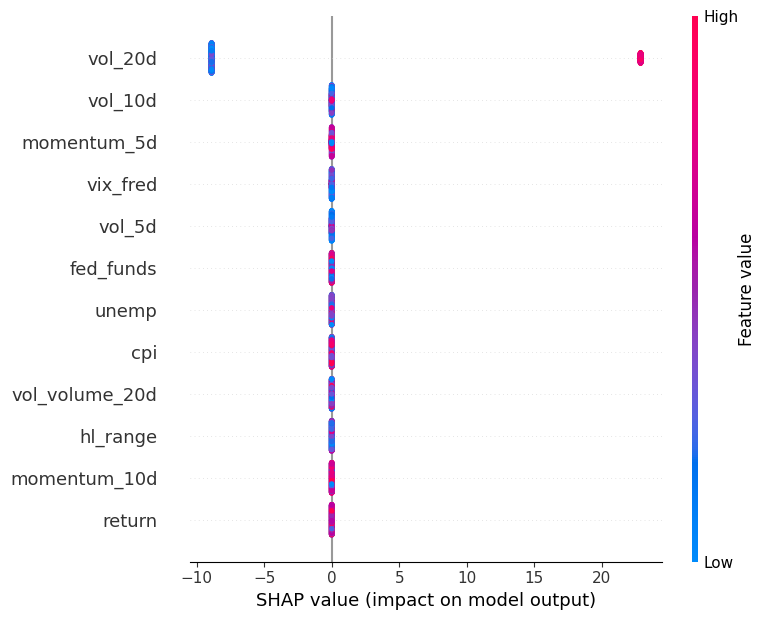

In [26]:
shap.summary_plot(shap_values, X_val)


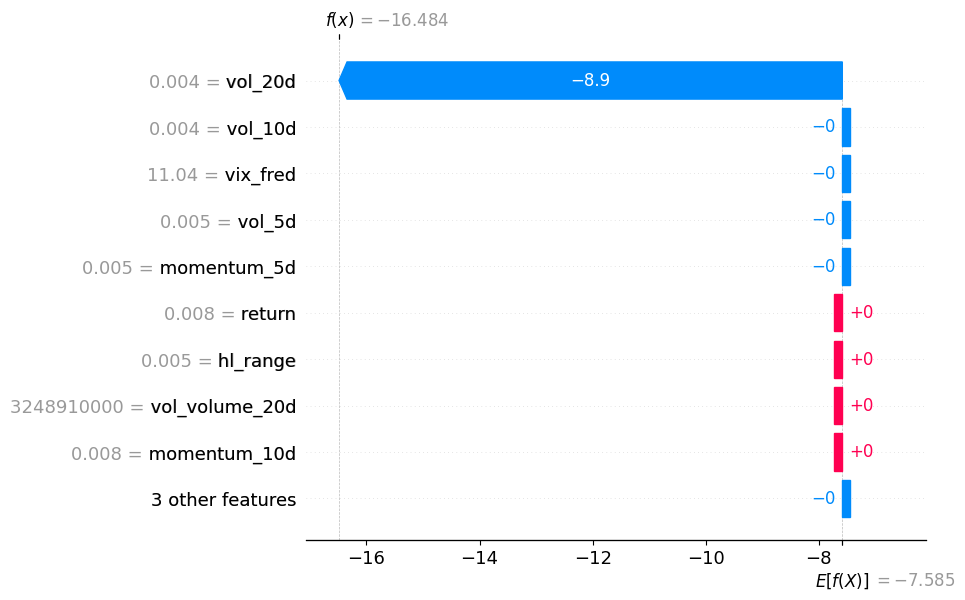

In [27]:
shap.plots.waterfall(shap_values[0])


In [28]:
p = gb.predict_proba(X_test)[:, 1]


In [29]:
def risk_alert(prob):
    if prob < 0.3:
        return "Normal"
    elif prob < 0.5:
        return "Watch"
    else:
        return "Alert"

alerts = pd.Series(p, index=X_test.index).apply(risk_alert)
alerts.value_counts()


,count
Normal,1071
Alert,449
